# Healthcare Final Project (Fall 2023): Prediction and Data Visualization of Sepsis
### Yihan Li (yl10798) Yantao Luo (yl5929)

In [59]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

## 1. Data Analysis and Preprocessing

In [60]:
sepsis_df = pd.read_csv('Dataset.csv')
sepsis_df = sepsis_df.drop(columns='Unnamed: 0')
sepsis_df = sepsis_df[sepsis_df['Patient_ID'] < 100000]
# df_train = combined.drop(rows_to_drop.index)
sepsis_df.to_csv('sepsis_df.csv', index=False)
sepsis_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [61]:
# Drop Administrative Data
columns_to_drop = ['Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
sepsis_df = sepsis_df.drop(columns=columns_to_drop)

### 1.1 Data Inspection

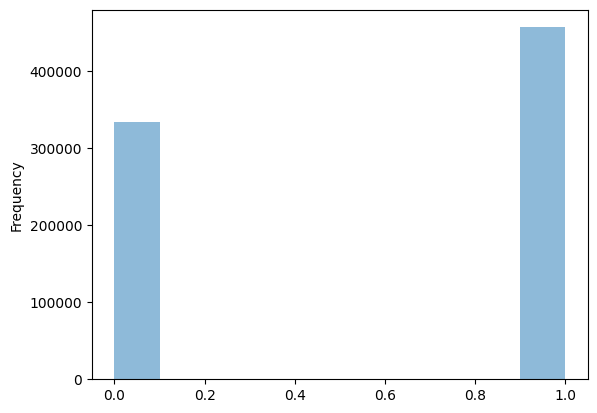

In [62]:
sepsis_df.Gender.plot.hist(alpha=0.5);

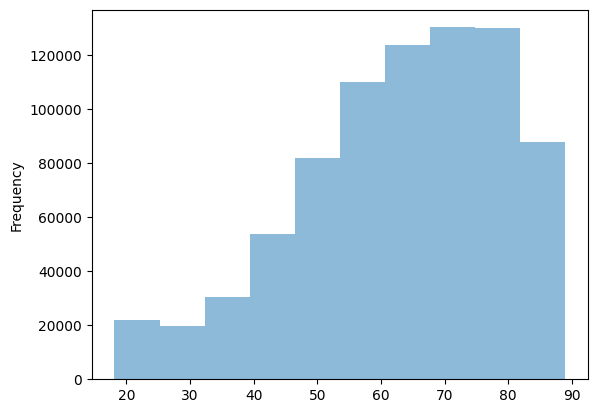

In [63]:
sepsis_df.Age.plot.hist(alpha=0.5);

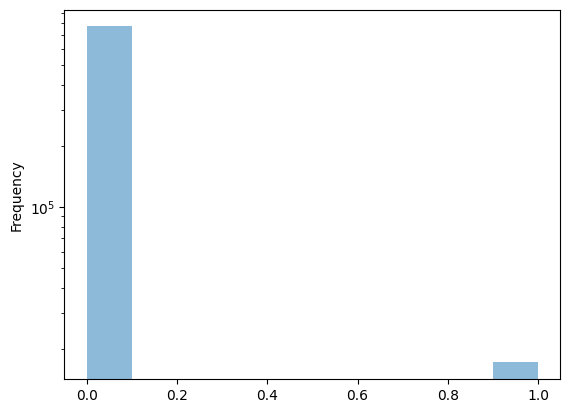

In [64]:
sepsis_df.SepsisLabel.plot.hist(alpha=0.5, logy=True);

### 1.2 Data Imputation

In [65]:
grouped_by_patient = sepsis_df.groupby('Patient_ID')
sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
sepsis_df.head()
# grouped_by_patient = sepsis_df.groupby('Patient_ID')
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer()
# imputer.fit(sepsis_df)
# sepsis_df = grouped_by_patient.apply(lambda x: pd.DataFrame(imputer.transform(x), columns=sepsis_df.columns))
# sepsis_df.head()

C:\Users\liyihan\AppData\Local\Temp\ipykernel_20688\1270594311.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,Patient_ID
0,0,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
1,1,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
2,2,78.0,100.0,35.78,129.0,42.5,69.0,17.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
3,3,73.0,100.0,35.78,129.0,74.0,69.0,17.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
4,4,70.0,100.0,35.78,129.0,74.0,69.0,14.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072


In [67]:
nan_percentage = sepsis_df.isnull().mean() * 100
threshold = 25

# Get columns where the percentage of NaN values is greater than the threshold
high_nan_columns = nan_percentage[nan_percentage > threshold]
sepsis_df = sepsis_df.drop(columns=high_nan_columns.index)
print("Columns with more than 25% NaN values:")
print(high_nan_columns)

Columns with more than 25% NaN values:
DBP                  32.667692
EtCO2               100.000000
BaseExcess           32.527224
FiO2                 36.195592
pH                   29.956784
PaCO2                32.839037
SaO2                 57.282891
AST                  66.435590
Alkalinephos         67.334207
Bilirubin_direct     96.256841
Lactate              55.997418
Bilirubin_total      66.949754
TroponinI            97.357934
Fibrinogen           85.019900
dtype: float64


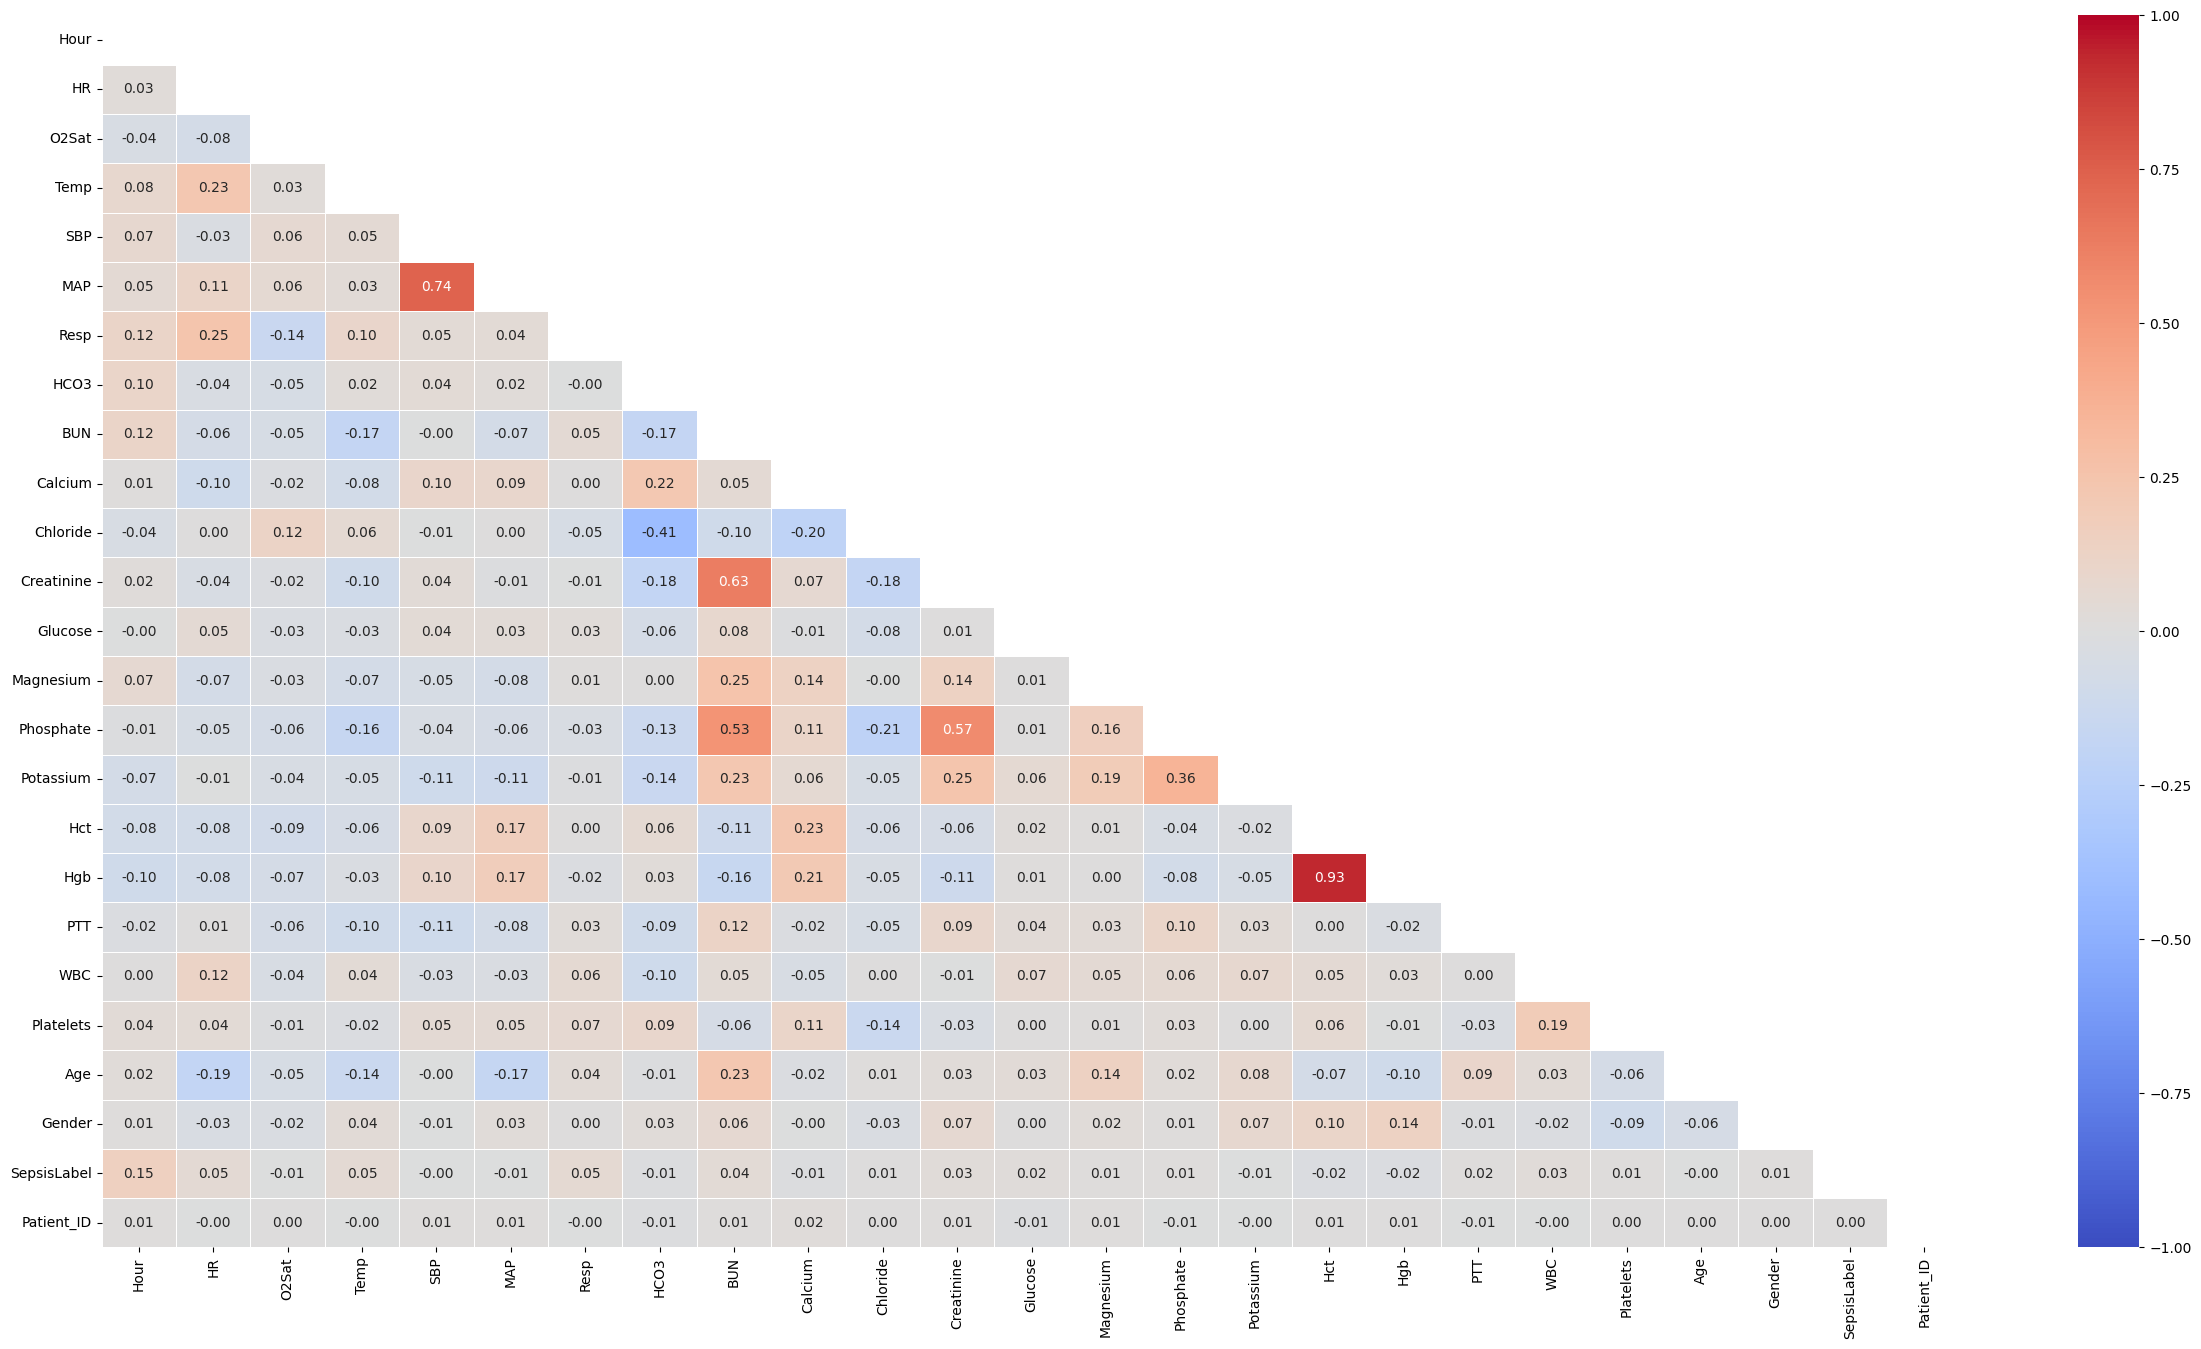

In [68]:
# correlation matrix to check the correlation between the remaining features
correlation_matrix = sepsis_df.corr()
plt.figure(figsize=(30, 16))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,       # Add correlation values to the squares
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)),
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Set the scale for the color bar
            fmt='.2f',        # Formatting numbers
            linewidths=.5)    # Space between cells

plt.show()

In [69]:
# columns = sepsis_df.columns

# # Create an empty DataFrame to store the p-values
# p_values = pd.DataFrame(index=columns, columns=columns)

# # Loop through the columns and calculate the p-values
# for col in columns:
#     # Calculate the Pearson correlation coefficient and the p-value
#     corr_test = pearsonr(sepsis_df['SepsisLabel'], sepsis_df[col])
#     # Assign the p-value to the correct position in the DataFrame
#     p_values.loc['SepsisLabel', col] = corr_test[1]

# # Convert all the p-value entries from objects to floats
# p_values = p_values.astype(float)

### 1.3 Sampling Train Set and Test Set

In [82]:
# Split training set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sepsis_df, test_size=0.2, train_size=0.8, random_state=1124, shuffle=True, stratify=None)
train_set.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,Resp,HCO3,BUN,Calcium,...,Potassium,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,SepsisLabel,Patient_ID
49865,9,115.0,96.0,36.83,137.0,82.0,23.0,26.0,6.0,7.7,...,3.5,23.4,8.4,27.0,6.3,158.0,26.99,0,0,213
152203,2,70.0,100.0,39.44,113.0,103.5,20.5,23.0,11.0,8.3,...,4.4,37.4,13.0,26.4,16.6,300.0,56.25,1,0,5601
256128,31,77.0,97.0,36.67,127.0,98.0,19.0,25.0,7.0,9.0,...,4.3,34.0,12.2,NaN,8.1,176.0,46.30,0,0,6764
68109,50,100.0,98.0,35.83,92.0,67.0,19.0,38.0,20.0,8.4,...,3.7,31.5,10.1,38.8,6.5,207.0,83.41,1,0,20611
753973,28,77.0,96.0,37.17,134.0,87.0,10.0,27.0,20.0,7.2,...,4.2,38.2,12.9,25.4,18.5,179.0,62.25,1,0,15007


In [83]:
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
    train_set[i] = np.log(train_set[i]+1)
    test_set[i] = np.log(test_set[i]+1)
    
pos_set = train_set[train_set.SepsisLabel == 1]
neg_set = train_set[train_set.SepsisLabel == 0]
neg_set = neg_set.sample(frac = 0.1)
train_set = pd.concat([pos_set,neg_set])

y_train = train_set.SepsisLabel
X_train = train_set.drop(columns=['SepsisLabel', 'Patient_ID'])
y_test = test_set.SepsisLabel
X_test = test_set.drop(columns=['SepsisLabel', 'Patient_ID'])

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# print(sorted(Counter(y_resampled).items()))
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[(0, 43005), (1, 60662)]


### 1.4 Correlation Analysis

#### KNN

In [72]:
from sklearn.neighbors import KNeighborsClassifier

k = 2
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# x_test = test_set.drop(columns=["Patient_ID", "SepsisLabel"])
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9146561378865246
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    154639
           1       0.20      0.97      0.33      3404

    accuracy                           0.91    158043
   macro avg       0.60      0.94      0.64    158043
weighted avg       0.98      0.91      0.94    158043



#### Logistic Regression

In [73]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.5772289819859152
              precision    recall  f1-score   support

           0       0.99      0.57      0.73    154639
           1       0.04      0.75      0.07      3404

    accuracy                           0.58    158043
   macro avg       0.51      0.66      0.40    158043
weighted avg       0.97      0.58      0.71    158043



In [74]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=10798)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
importances = forest.feature_importances_
print('Importances: ', importances)
indices = np.argsort(importances)[::-1]
print('Importance sort:', indices)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    154639
           1       0.26      0.97      0.41      3404

    accuracy                           0.94    158043
   macro avg       0.63      0.96      0.69    158043
weighted avg       0.98      0.94      0.96    158043

Importances:  [0.17877425 0.04811695 0.02589798 0.05933744 0.02778265 0.02042977
 0.04435698 0.03855174 0.05032763 0.03553578 0.03462854 0.04833678
 0.03298641 0.03122624 0.03332935 0.02952722 0.03383906 0.03584446
 0.04717051 0.04188823 0.03763561 0.04314147 0.02133496]
Importance sort: [ 0  3  8 11  1 18  6 21 19  7 20 17  9 10 16 14 12 13 15  4  2 22  5]


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(X_train.shape[1], 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
    def forward(self, X):
        X = self.linear1(X)
        X = F.leaky_relu(X)
        X = self.linear2(X)
        X = F.leaky_relu(X)
        X = self.linear3(X)
        return torch.sigmoid(X)
        


In [85]:
from torch.utils.data import DataLoader, Dataset
class SepsisDataset(Dataset):
    def __init__(self, flag='train', X=None, y=None):
        assert flag in ['train', 'test', 'valid']
        self.flag = flag
        self.X = X
        self.y = y

    def __getitem__(self, index):
        
        return self.X[index, :], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]


train_set = np.concatenate([X_train, np.expand_dims(y_train, axis=1)], axis=1)
train_set, valid_set = train_test_split(train_set, test_size=0.1, train_size=0.9, random_state=10798, shuffle=True, stratify=None)
X_train = train_set[:,:-1]
y_train = train_set[:,-1:]
X_valid = valid_set[:,:-1]
y_valid = valid_set[:,-1:]
y_test = np.expand_dims(y_test, axis=1)

train_dataset = SepsisDataset(flag='train', X=X_train, y=y_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_dataset = SepsisDataset(flag='valid', X=X_valid, y=y_valid)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_dataset = SepsisDataset(flag='test', X=X_test, y=y_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [86]:
model = FCN().to('cuda:0')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []


In [ ]:
from tqdm import tqdm
num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_dataloader,0):
        data_x = data_x.to(torch.float32).to('cuda:0')
        data_y = data_y.to(torch.float32).to('cuda:0')
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y,outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
#         if idx%(len(train_dataloader)//2)==0:
#             print("epoch={}/{},{}/{}of train, loss={}".format(
#                 epoch, num_epochs, idx, len(train_dataloader),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))
    
    #=====================valid============================
    model.eval()
    valid_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(valid_dataloader,0):
        data_x = data_x.to(torch.float32).to('cuda:0')
        data_y = data_y.to(torch.float32).to('cuda:0')
        outputs = model(data_x)
        loss = criterion(data_y,outputs)
        valid_epoch_loss.append(loss.item())
        valid_loss.append(loss.item())
    valid_epochs_loss.append(np.average(valid_epoch_loss))


 32%|█████████████████████████████▌                                                                | 63/200 [03:26<07:25,  3.25s/it]

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
val = torch.tensor(X_test).reshape(1, -1).float().to("cuda:0")
# 需要转换成相应的输入shape，而且得带上batch_size，因此转换成shape=(1,1)这样的形状
results = [0, 0, 0, 0] # FN, FP, TN, TP
for idx,(data_x,data_y) in enumerate(test_dataloader,0):
    target = int(data_y.item())
    data_x = data_x.to(torch.float32).to('cuda:0')
    data_y = data_y.to(torch.float32).to('cuda:0')
    res0 = model(data_x)
    res = 1 if res0.item() > 0.5 else 0
    TF = 1 if res == data_y else 0
    results[TF * 2 + res] += 1
#     if ((idx+1) % 1000 == 0):
#         print(results, data_y.item(), res0.item(), res)
    
pos_precision = results[3] / (results[3] + results[1])
pos_recall = results[3] / (results[3] + results[0])
neg_precision = results[2] / (results[2] + results[0])
neg_recall = results[2] / (results[2] + results[1])
print("Precision            Recall")
print("pos_precision     pos_recall")
print("neg_precision     neg_recall")

In [ ]:
print("Precision            Recall")
print(pos_precision,   pos_recall)
print(neg_precision,   neg_recall)